# LSTM and GRU with cortical electrophys
This notebook is part of the [SachsLab Workshop for Intracranial Neurophysiology and Deep Learning](https://github.com/SachsLab/IntracranialNeurophysDL).

Follow the link below to run in Google Colab or continue if running locally.

Run the first three cells to normalize Local / Colab environments, then proceed below for the lesson.

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/SachsLab/IntracranialNeurophysDL/blob/master/notebooks/05_02_LSTM_and_GRU.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/SachsLab/IntracranialNeurophysDL/blob/master/notebooks/05_02_LSTM_and_GRU.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

In [0]:
%load_ext autoreload
%autoreload 2

In [1]:
from pathlib import Path
import os
try:
    # See if we are running on google.colab
    import google.colab
    from google.colab import files
    os.chdir('..')
    if not (Path.home() / '.kaggle').is_dir():
        # Configure kaggle
        files.upload()  # Find the kaggle.json file in your ~/.kaggle directory.
        !pip install -q kaggle
        !mkdir -p ~/.kaggle
        !mv kaggle.json ~/.kaggle/
        !chmod 600 ~/.kaggle/kaggle.json
    if Path.cwd().stem != 'IntracranialNeurophysDL':
        if not (Path.cwd() / 'IntracranialNeurophysDL').is_dir():
            # Download the workshop repo and change to its directory
            !git clone --recursive https://github.com/SachsLab/IntracranialNeurophysDL.git
        os.chdir('IntracranialNeurophysDL')
    IN_COLAB = True
    # Setup tensorflow 2.0
    !pip install -q tensorflow-gpu==2.0.0-alpha0
except ModuleNotFoundError:
    IN_COLAB = False
    import sys
    if Path.cwd().stem == 'notebooks':
        os.chdir(Path.cwd().parent)
    # Make sure the kaggle executable is on the PATH
    os.environ['PATH'] = os.environ['PATH'] + ';' + str(Path(sys.executable).parent / 'Scripts')

# Try to clear any logs from previous runs
if (Path.cwd() / 'logs').is_dir():
    import shutil
    try:
        shutil.rmtree(str(Path.cwd() / 'logs'))
    except PermissionError:
        print("Unable to remove logs directory.")

# Additional imports
import tensorflow as tf
import datetime
import numpy as np
import matplotlib.pyplot as plt
from indl import enable_plotly_in_cell
%load_ext tensorboard.notebook

Saving kaggle.json to kaggle.json
Cloning into 'IntracranialNeurophysDL'...
remote: Enumerating objects: 162, done.
remote: Counting objects: 100% (162/162), done.
remote: Compressing objects: 100% (121/121), done.
remote: Total 551 (delta 92), reused 100 (delta 41), pack-reused 389
Receiving objects: 100% (551/551), 14.62 MiB | 10.22 MiB/s, done.
Resolving deltas: 100% (303/303), done.
     |████████████████████████████████| 332.1MB 51kB/s 
     |████████████████████████████████| 61kB 28.3MB/s 
     |████████████████████████████████| 3.0MB 46.0MB/s 
     |████████████████████████████████| 419kB 49.8MB/s 


In [2]:
# Download and unzip data (2.1 GB)
datadir = Path.cwd() / 'data' / 'joeyo'
if not (datadir / 'converted').is_dir():
    !kaggle datasets download --unzip --path {str(datadir / 'converted')} cboulay/joeyo_nhp_reach_mea
    print("Finished downloading and extracting data.")
else:
    print("Data directory found. Skipping download.")

100% 2.09G/2.10G [00:31<00:00, 59.5MB/s]
100% 2.10G/2.10G [00:31<00:00, 72.4MB/s]
Finished downloading and extracting data.


## Prepare Data

### Import

Import 1 session of data. We can use the `x_chunk` argument to select different types of neural data to import. The options are 'spiketimes', 'mu_spiketimes', 'su_rates', and 'mu_rates' (mu = multiunit, where all different units are squashed down to one unit per electrode).

Y, the behavioural data, has finger position (3-D), cursor position (2-D; direct projection of finger position), and the target position. We need only the cursor position, so we select only those channels from Y. We also want the velocity and acceleration. These were not recorded explicitly but we can calculate them easily with a discrete derivative.

In [0]:
from data.utils.fileio import load_joeyo_reaching

def load_dat_with_vel_accel(datadir, sess_idx):
    BEHAV_CHANS = ['CursorX', 'CursorY']
    sess_names = ['indy_201' + _ for _ in ['60921_01', '60927_04', '60927_06', '60930_02', '60930_05', '61005_06',
                                       '61006_02', '60124_01', '60127_03']]
    X, Y, X_ax_info, Y_ax_info = load_joeyo_reaching(datadir, sess_names[sess_idx], x_chunk='mu_spiketimes')

    # Slice Y to only keep required behaviour data (cursor position)
    b_keep_y_chans = np.in1d(Y_ax_info['channel_names'] , BEHAV_CHANS)
    Y = Y[b_keep_y_chans, :]
    Y_ax_info['channel_names'] = [_ for _ in Y_ax_info['channel_names'] if _ in BEHAV_CHANS]

    # Calculate discrete derivative and double-derivative to get velocity and acceleration.
    vel = np.diff(Y, axis=1)
    vel = np.concatenate((vel[:, 0][:, None], vel), axis=1)  # Assume velocity was constant across the first two samples.
    accel = np.concatenate(([[0], [0]], np.diff(vel, axis=1)), axis=1)  # Assume accel was 0 in the first sample.
    Y = np.concatenate((Y, vel, accel), axis=0)
    Y_ax_info['channel_names'] += ['VelX', 'VelY', 'AccX', 'AccY']
    
    return X, Y, X_ax_info, Y_ax_info

SESS_IDX = 0
X, Y, X_ax_info, Y_ax_info = load_dat_with_vel_accel(datadir, SESS_IDX)

### Bin Spike Times
Almost everyone working with these type of data convert spike times to rates. We are no different.

First we count spikes in each bin. [Ahmadi et al.](https://arxiv.org/pdf/1901.00708.pdf), using some of these same data, had optimal classification performance with a bin width of 256 msec and 2 taps (see below). Alternatively, [Tseng et al.](https://www.mitpressjournals.org/doi/abs/10.1162/neco_a_01189) used 50-msec binning with 30 taps.

The window will slide 4-msec at a time, aligning with the behavioural data rate.

In [0]:
def bin_spike_times(X, X_ax_info, bin_duration=0.256, bin_step_dur=0.004):
    bin_starts_t = np.arange(X_ax_info['timestamps'][0], X_ax_info['timestamps'][-1], bin_step_dur)
    bin_starts_idx = np.searchsorted(X_ax_info['timestamps'], bin_starts_t)
    bin_samples = int(np.ceil(bin_duration * X_ax_info['fs']))

    # This step is slow and probably could be optimized.
    _X = np.array([X[:, bin_start:bin_start+bin_samples].getnnz(1) for bin_start in bin_starts_idx])
    _X = _X / bin_duration  # Convert to spike rates
    return _X, bin_starts_t, bin_samples
    
BIN_DURATION = 0.256
_X, bin_starts_t, bin_samples = bin_spike_times(X, X_ax_info, bin_duration=BIN_DURATION, bin_step_dur=(1 / Y_ax_info['fs']))

### Visualize Data

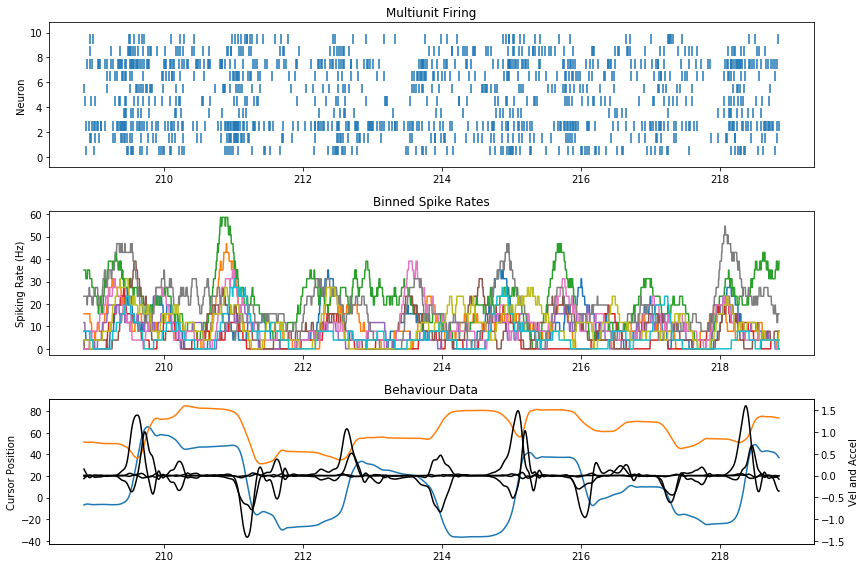

In [32]:
PLOT_T_RANGE = [30, 40]
X_SKIP_NEURONS = 9

plt_t_range = np.array(PLOT_T_RANGE, dtype=np.float64)
plt_t_range += Y_ax_info['timestamps'][0]

fig = plt.figure(figsize=(12, 8), facecolor='white')

# Raster Plot
plt.subplot(3, 1, 1)
# identify which samples in X fall within our time range
b_x = np.logical_and(X_ax_info['timestamps'] >= plt_t_range[0],
                     X_ax_info['timestamps'] < plt_t_range[1])
t_x = X_ax_info['timestamps'][b_x]  # vector of timestamps
X_subset = X[::X_SKIP_NEURONS, b_x]
# X is sparse. We use nonzero() to get its indices,
# then use the indices to index our timestamp vector to get spike times.
spk_t_list = [t_x[_.nonzero()[1]] for _ in X_subset]
plt.eventplot(spk_t_list, lineoffsets=0.5+np.arange(len(spk_t_list)), linelengths=0.8)
# plt.plot(t_vec[1000:2000], X[::10, b_x_ts].T)
plt.title('Multiunit Firing')
plt.ylabel('Neuron')

# Spike Rate Plot
plt.subplot(3, 1, 2)
b_bins = np.logical_and(bin_starts_t >= plt_t_range[0], bin_starts_t < plt_t_range[1])
plt.plot(bin_starts_t[b_bins], _X[b_bins, ::X_SKIP_NEURONS])
plt.title('Binned Spike Rates')
plt.ylabel('Spiking Rate (Hz)')

# Behaviour Plot
plt.subplot(3, 1, 3)
b_y = np.logical_and(Y_ax_info['timestamps'] >= plt_t_range[0],
                     Y_ax_info['timestamps'] < plt_t_range[1])
plt.plot(Y_ax_info['timestamps'][b_y], Y[:2, b_y].T)
plt.ylabel('Cursor Position')
ax2 = plt.twinx()
ax2.plot(Y_ax_info['timestamps'][b_y], Y[2:, b_y].T, 'k')
plt.ylabel('Vel and Accel')
plt.title('Behaviour Data')
plt.xlabel('Time (s)')

plt.tight_layout()
plt.show()

### Convert to 32-bit
TensorFlow likes its arrays to be 32-bit (or even 16-bit). We could ask TensorFlow to do it for us, but we do it ourselves now because it makes the next step easier.

In [0]:
_X = _X.astype(np.float32)
Y = Y.astype(np.float32)

### Sequence Length a.k.a. Number of Timesteps a.k.a. Taps

Neural data needs to be in shape (steps, taps, channels) where `taps` is the number of steps of neural data history used to predict each step in behaviour. In the below figure, there are 3 bins of spikes being used for every behaviour step.

![bin_taps](https://github.com/SachsLab/IntracranialNeurophysDL/blob/master/notebooks/img/spike_binning_with_taps.png?raw=1)

This requires us to duplicate our neural data B bins times. This is a huge waste of memory, especially if our number of taps gets larger.

#### Detour: Strides
An array's memory is laid out contiguously. Python/numpy maps from different dimensions in a tensor to different memory addresses by the array's strides.

In [20]:
print(_X.shape, _X.strides, _X.shape[-1] * _X.strides[-1], _X.T.strides)

(90037, 88) (704, 8) 704 (8, 704)


This means that for every step in the last dimension of _X (i.e., columns in a row), advance 4 bytes (np.float32 = 32 bits = 4 bytes). Then, for every step in the next-from-last dimension (i.e., rows), advance 352 bytes; 352 = 4 bytes per sample * 88 columns per row.

We can ask numpy to create a new array, backed by the same contiguous memory, but with a different striding strategy, one that has multiple elements in the array coming from the same memory address. You can find a [more detailed answer on StackOverflow](https://stackoverflow.com/a/46199050/1256069).

While we are at it, we should recalculate the timestamps for the neural data as the last timestamp in the last tap. And we should slice our Y data to only include steps that start after the first such timestamp.

In [10]:
def get_binned_rates_with_history(_X, X_ax_info, bin_starts_t, bin_samples, n_taps=3):
    bin_stops_t = bin_starts_t + bin_samples / X_ax_info['fs']
    bin_stops_t = bin_stops_t[(N_TAPS-1):]

    _Y = Y[2:4, Y_ax_info['timestamps'] > bin_stops_t[0]].T

    _X_tapped = np.lib.stride_tricks.as_strided(_X, shape=(_Y.shape[0], N_TAPS, _X.shape[-1]),
                                                strides=(_X.strides[-2], _X.strides[-2], _X.strides[-1]))
    return _X_tapped, _Y, bin_stops_t

N_TAPS = 3
_X_tapped, _Y, bin_stops_t = get_binned_rates_with_history(_X, X_ax_info, bin_starts_t, bin_samples, n_taps=N_TAPS)

# Confirm _X_tapped contents:
print(_X_tapped[10:20, :, 0])

[[27.34375 27.34375 31.25   ]
 [27.34375 31.25    31.25   ]
 [31.25    31.25    31.25   ]
 [31.25    31.25    31.25   ]
 [31.25    31.25    31.25   ]
 [31.25    31.25    31.25   ]
 [31.25    31.25    31.25   ]
 [31.25    31.25    35.15625]
 [31.25    35.15625 35.15625]
 [35.15625 35.15625 35.15625]]


### Prepare for TensorFlow

First we split into training and validation sets. Then, using the training set only, we calculate the mean and standard deviation so that we can z-score X and center Y.

In [0]:
def prepare_for_tensorflow(_X_tapped, _Y, p_train=0.8, batch_size=32):
    valid_start = int(np.ceil(_X_tapped.shape[0] * P_TRAIN))

    # Get mean and std of training X data for z-scoring, same for Y
    _X_mean = np.nanmean(_X_tapped[:valid_start, 0, :], axis=0)
    _X_std = np.nanstd(_X_tapped[:valid_start, 0, :], axis=0)
    _Y_mean = np.nanmean(_Y[:valid_start, :], axis=0, keepdims=True)
    _Y_std = np.nanstd(_Y[:valid_start, :], axis=0, keepdims=True)

    _X_tapped = (_X_tapped - _X_mean[None, None, :]) / _X_std[None, None, :]
    _Y = (_Y - _Y_mean)  # / _Y_std  # Only standardize Y if top layer demands it.

    ds_train = tf.data.Dataset.from_tensor_slices((_X_tapped[:valid_start], _Y[:valid_start]))
    ds_valid = tf.data.Dataset.from_tensor_slices((_X_tapped[valid_start:], _Y[valid_start:]))

#     ds_train = ds_train.shuffle(int(_X_tapped.shape[0] * P_TRAIN) + 1)
    ds_train = ds_train.batch(BATCH_SIZE, drop_remainder=True)
    ds_valid = ds_valid.batch(BATCH_SIZE, drop_remainder=True)
    
    return _X_tapped, _Y, ds_train, ds_valid

P_TRAIN = 0.8
BATCH_SIZE = 32
_X_tapped, _Y, ds_train, ds_valid = prepare_for_tensorflow(_X_tapped, _Y, p_train=P_TRAIN, batch_size=BATCH_SIZE)

## Long Short-Term Memory (LSTM) and Gated Recurrent Unit (GRU)
[This blog post](https://colah.github.io/posts/2015-08-Understanding-LSTMs/) from mid-2015 is still one of the best explanations of LSTMs around. The short of it is that each LSTM cell has three functions or 'gates' that decide (on each step) how much of the state (forget gate) gets combined with how much of the input (update gate) to make the new state, and how much of the input gets combined with the state to make the output (output gate).

GRUs are similar in concept but use only two gates: an update gate and a reset gate. [See here](https://arxiv.org/pdf/1412.3555v1.pdf).

As such, LSTMs are slightly more sophisticated and theoretically could model more of your model space, but in practice GRUs usually do just as well and are more efficient computationally. We will quickly try each version.

### Implementation Details
This will probably change, but the unification of LSTM APIs in TensorFlow 2.0 means that there are some constraints on how an LSTM can be parameterized and still run on the GPU.

1. activation == 'tanh'
2. recurrent_activation == 'sigmoid'
3. recurrent_dropout == 0
4. unroll is False
5. use_bias is True
6. No use of masking.

In [13]:
def make_model(input_shape, output_shape, n_rnn_units=100, p_dropout=0.3, l2_reg=0.001, stateful=False):
    # Note: batch_shape, not shape, if using stateful
    if stateful:
        inputs = tf.keras.layers.Input(batch_shape=input_shape)
    else:
        inputs = tf.keras.layers.Input(shape=input_shape)
    _y = tf.keras.layers.LSTM(n_rnn_units, dropout=p_dropout, recurrent_dropout=0,
                              kernel_regularizer=tf.keras.regularizers.l2(l2_reg),
                              recurrent_regularizer=tf.keras.regularizers.l2(l2_reg),
                              return_sequences=False, stateful=stateful)(inputs)
    if p_dropout > 0.0:
        _y = tf.keras.layers.Dropout(p_dropout)(_y)
    outputs = tf.keras.layers.Dense(output_shape, activation='linear')(_y)
    model = tf.keras.Model(inputs, outputs)
    model.compile(optimizer='rmsprop', loss='mean_squared_error')
    return model

P_DROPOUT = 0.3
N_RNN_UNITS = 100
L2_REG = 0.001
STATEFUL = False

input_shape = _X_tapped.shape[1:]
if STATEFUL:
    input_shape = (BATCH_SIZE,) + input_shape
    
model = make_model(input_shape, _Y.shape[1], n_rnn_units=N_RNN_UNITS, p_dropout=P_DROPOUT, l2_reg=L2_REG, stateful=STATEFUL)
model.summary()

W0606 16:56:28.439258 139926858688384 tf_logging.py:161] <tensorflow.python.keras.layers.recurrent.UnifiedLSTM object at 0x7f42d4fc8ac8>: Note that this layer is not optimized for performance. Please use tf.keras.layers.CuDNNLSTM for better performance on GPU.


Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 3, 88)]           0         
_________________________________________________________________
unified_lstm_1 (UnifiedLSTM) (None, 100)               75600     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 202       
Total params: 75,802
Trainable params: 75,802
Non-trainable params: 0
_________________________________________________________________


In [14]:
EPOCHS = 10
history = model.fit(x=ds_train, epochs=EPOCHS, verbose=1, validation_data=ds_valid)

W0606 16:56:39.166457 139926858688384 training_utils.py:1353] Expected a shuffled dataset but input dataset `x` is not shuffled. Please invoke `shuffle()` on input dataset.


Epoch 1/10
2249/2249 [==============================] - 18s 8ms/step - loss: 0.1136 - val_loss: 0.0675
Epoch 2/10
2249/2249 [==============================] - 12s 6ms/step - loss: 0.0604 - val_loss: 0.0640
Epoch 3/10
2249/2249 [==============================] - 13s 6ms/step - loss: 0.0576 - val_loss: 0.0612
Epoch 4/10
2249/2249 [==============================] - 13s 6ms/step - loss: 0.0557 - val_loss: 0.0582
Epoch 5/10
2249/2249 [==============================] - 13s 6ms/step - loss: 0.0552 - val_loss: 0.0561
Epoch 6/10
2249/2249 [==============================] - 13s 6ms/step - loss: 0.0544 - val_loss: 0.0560
Epoch 7/10
2249/2249 [==============================] - 13s 6ms/step - loss: 0.0545 - val_loss: 0.0555
Epoch 8/10
2249/2249 [==============================] - 13s 6ms/step - loss: 0.0538 - val_loss: 0.0569
Epoch 9/10
2249/2249 [==============================] - 13s 6ms/step - loss: 0.0532 - val_loss: 0.0578
Epoch 10/10
2249/2249 [==============================] - 13s 6ms/step - l

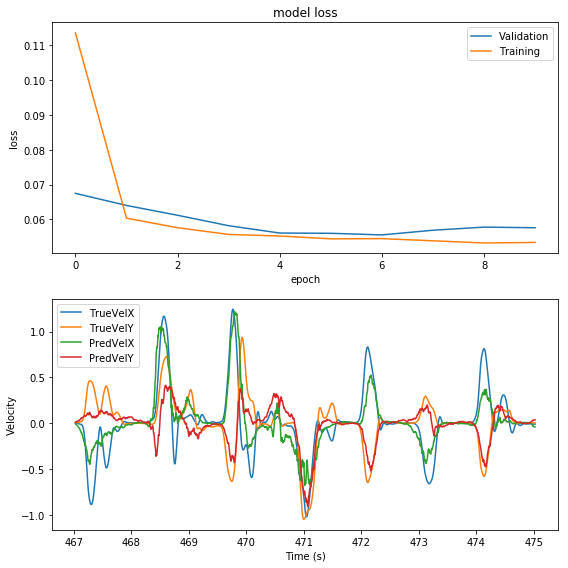

In [16]:
PLOT_SAMPLES = 2000
fig = plt.figure(figsize=(8, 8), facecolor='white')

plt.subplot(2, 1, 1)
plt.plot(history.history['val_loss'], label='Validation')
plt.plot(history.history['loss'], label='Training')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(loc='upper right')

plt.subplot(2, 1, 2)
valid_start = int(np.ceil(_X_tapped.shape[0] * P_TRAIN))
pred_y = model.predict(x=_X_tapped[valid_start:valid_start + PLOT_SAMPLES])
plt.plot(bin_stops_t[valid_start:valid_start + PLOT_SAMPLES], _Y[valid_start:valid_start + PLOT_SAMPLES, :])
plt.plot(bin_stops_t[valid_start:valid_start + PLOT_SAMPLES], pred_y[:, :])
for ix, label in enumerate(['TrueVelX', 'TrueVelY', 'PredVelX', 'PredVelY']):
    plt.gca().lines[ix].set_label(label)
plt.xlabel('Time (s)')
plt.ylabel('Velocity')
plt.legend()

plt.tight_layout()
plt.show()

# Hyperparameter Optimization

We'll use a library called `hyperopt`. This runs a function with different sets of parameters and chooses the parameter set that minimizes the return. So let's define a function that runs our data prep, trains the model, and returns the validation loss.

In [0]:
def lstm_evaluate(params):
    bin_duration = params['bin_duration']
    n_taps = params['n_taps']
    batch_size = params['batch_size']
    p_dropout = params['p_dropout']
    n_rnn_units = params['n_rnn_units']
    l2_reg = params['l2_reg']
    epochs = params['epochs']
    
    X, Y, X_ax_info, Y_ax_info = load_dat_with_vel_accel(datadir, SESS_IDX)
    _X, bin_starts_t, bin_samples = bin_spike_times(X, X_ax_info, bin_duration=bin_duration, bin_step_dur=(1 / Y_ax_info['fs']))
    _X = _X.astype(np.float32)
    Y = Y.astype(np.float32)
    _X_tapped, _Y, bin_stops_t = get_binned_rates_with_history(_X, X_ax_info, bin_starts_t, bin_samples, n_taps=n_taps)
    _X_tapped, _Y, ds_train, ds_valid = prepare_for_tensorflow(_X_tapped, _Y, p_train=P_TRAIN, batch_size=batch_size)
    input_shape = _X_tapped.shape[1:]
    model = make_model(_X_tapped.shape[1:], _Y.shape[1], n_rnn_units=n_rnn_units, p_dropout=p_dropout, l2_reg=l2_reg)
    history = model.fit(x=ds_train, epochs=epochs, verbose=1, validation_data=ds_valid)
    return history.history['val_loss'][-1]
    

In [0]:
from hyperopt import fmin, hp, Trials, tpe, STATUS_OK
#The range of values I'll look at for the parameter
#"hp.quniform" will allow us to look at integer (rather than continuously spaced) values.
#So for "num_units", we are looking at values between 50 and 700 by 10 (50,60,70,...700)
#"hp.uniform" looks at continuously spaced values
space = {
    'bin_duration': hp.loguniform('bin_duration', 0.05, 0.5),
    'n_taps': hp.quniform('n_taps', 1, 10, 1),
    'batch_size': hp.quniform('batch_size', 16, 128, 16),
    'p_dropout': hp.uniform('p_dropout', 0., 0.5),
    'n_rnn_units': hp.quniform('n_rnn_units', 50, 700, 10),
    'l2_reg': hp.loguniform('l2_reg', 0.0001, 0.1),
    'epochs': hp.quniform('epochs', 2, 15, 1),
}

#object that holds iteration results
trials = Trials()
#Do optimization
#Set the number of evaluations below (20 in this example)
hyperoptBest = fmin(lstm_evaluate, space, algo=tpe.suggest, max_evals=20, trials=trials)

  0%|          | 0/20 [00:00<?, ?it/s, best loss: ?]

## Related Studies

* [Ahmadi et al](https://arxiv.org/pdf/1901.00708.pdf)
    * Uses same datasets [-2, -1]
* [Glaser et al., arxiv 2018](https://arxiv.org/abs/1708.00909)
    * Great tutorial
    * [with code!](https://github.com/KordingLab/Neural_Decoding)
* [Park and Kim, IEEE APSIPA ASC 2018](https://ieeexplore.ieee.org/abstract/document/8659760)
* [Tseng et al... Nicolelis, IEEE Neural Computation 2019](https://www.mitpressjournals.org/doi/abs/10.1162/neco_a_01189)
    * "1000 iterations of training with a batch size of 64 and unrolling of 30 steps (equivalent to 1.5 s as each time step was 50 ms)".    
    * Tested 1-layer and 2-layer networks, 2-layer widening was best, with dropout=0.2
* [Wang et al., EMBC 2018](https://ieeexplore.ieee.org/abstract/document/8512609)
    * Decoding hindlimb kinematics.
    * seq_length=3; N_RNN_UNITS=200; lr=0.001; neural_dropout=0.2; batch_size=32; epochs=100
